# Imports

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import pickle as pkl
import seaborn as sns
from scipy.stats import norm
from scipy.stats import ttest_ind, ttest_rel, ranksums, wilcoxon

In [2]:
from backend import data_paths
from backend import evaluation_utils

# Load Return Period Metrics

In [3]:
_DATASET_RETURN_PERIOD_METRICS_PATH = {
    'google_2014': data_paths.GOOGLE_2014_RETURN_PERIOD_METRICS_DIR,
    'google_1980': data_paths.GOOGLE_1980_RETURN_PERIOD_METRICS_DIR,
    'glofas_2014': data_paths.GLOFAS_v3_REANALYSIS_2014_RETURN_PERIOD_METRICS_DIR,
    'glofas_1980': data_paths.GLOFAS_v3_REANALYSIS_1980_RETURN_PERIOD_METRICS_DIR,
}

In [4]:
precisions_by_lead_time = {}
recalls_by_lead_time = {}

precisions_by_return_period = {}
recalls_by_return_period = {}

for dataset, data_path in _DATASET_RETURN_PERIOD_METRICS_PATH.items():
    print(f'Working on {dataset} ...')
    file_path = data_paths.CONCATENATED_RETURN_PERIOD_DICTS_DIR / f'{dataset}_return_period_dicts.pkl'
    with open(file_path, 'rb') as f:
        precisions_by_lead_time[dataset], recalls_by_lead_time[dataset] = pkl.load(f)
    print(f'Finished loading {dataset}. \n')

Working on google_2014 ...
Finished loading google_2014. 

Working on google_1980 ...
Finished loading google_1980. 

Working on glofas_2014 ...
Finished loading glofas_2014. 

Working on glofas_1980 ...
Finished loading glofas_1980. 



# Global Precision & Recall Distributions

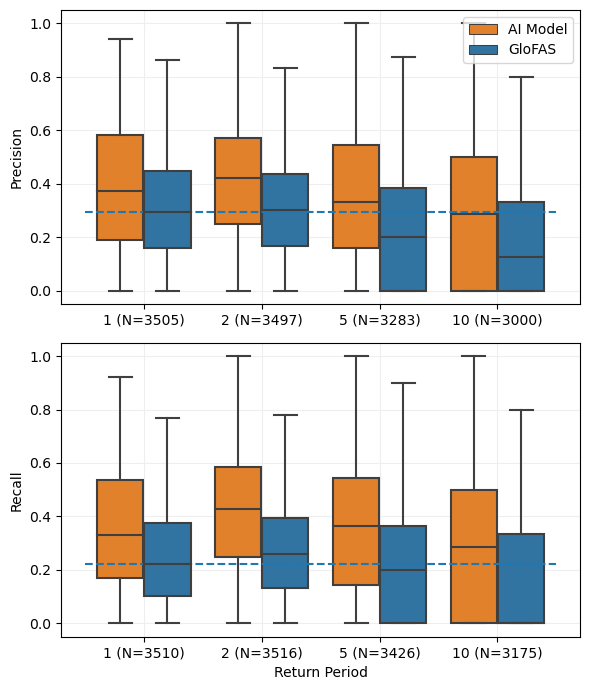

In [5]:
lead_time = 0
baseline_experiment = 'kfold_splits'
comparison_experiment = 'glofas_reanalysis'
use_return_periods = evaluation_utils.RETURN_PERIODS[:-2]

fig, axes = plt.subplots(2, 1, figsize=(6, 7))

# -----

metric = 'Precision'
df1 = precisions_by_lead_time['google_1980'][baseline_experiment][lead_time][use_return_periods].copy()
df2 = precisions_by_lead_time['glofas_1980'][comparison_experiment][lead_time][use_return_periods].copy()

# Make sure that we compare apples to apples by dropping any gauge with a nan from either model.
for return_period in use_return_periods:
    df_merged = pd.concat(
        [
            df1[return_period].rename('google'),
            df2[return_period].rename('glofas')
        ], axis=1).dropna()
    df1[return_period] = df_merged['google'].rename(return_period)
    df2[return_period] = df_merged['glofas'].rename(return_period)

df1['Model'] = evaluation_utils.EXPERIMENT_NAMES[baseline_experiment]
df2['Model'] = evaluation_utils.EXPERIMENT_NAMES[comparison_experiment]
df = pd.concat([df1, df2,], axis=0)
df.reset_index(inplace=True)
dd = pd.melt(df, id_vars=['index', 'Model'], value_vars=use_return_periods, var_name='Return Period')
dd.rename(columns={'value': metric}, inplace=True)

# Add sample size to x-tick labels
dd.dropna(inplace=True)
dd['Return Period'] = [int(val) for val in dd['Return Period']]
return_period_sample_size = dd['Return Period'].value_counts()
dd['Return Period'] = [f'{val} (N={int(return_period_sample_size[val]/2)})' for val in dd['Return Period']]

bp_colors = [evaluation_utils.COLORS[1], evaluation_utils.COLORS[0]]
bp = sns.boxplot(ax=axes[0], data=dd, x='Return Period', y=metric, hue='Model', showfliers=False, palette=bp_colors)
axes[0].grid(c='#EEE')
axes[0].set_axisbelow(True)
axes[0].get_legend()
# axes[0].set_xticks([])
axes[0].set_xlabel(None)
axes[0].legend(loc='upper right')

axes[0].plot([-0.5, 3.5], [df2[1.01].median()]*2, c=evaluation_utils.COLORS[0], ls='--')

# -----

metric = 'Recall'
df1 = recalls_by_lead_time['google_1980'][baseline_experiment][lead_time][use_return_periods].copy()
df2 = recalls_by_lead_time['glofas_1980'][comparison_experiment][lead_time][use_return_periods].copy()

# Make sure that we compare apples to apples by dropping any gauge with a nan from either model.
for return_period in use_return_periods:
    df_merged = pd.concat(
        [
            df1[return_period].rename('google'),
            df2[return_period].rename('glofas')
        ], axis=1).dropna()
    df1[return_period] = df_merged['google'].rename(return_period)
    df2[return_period] = df_merged['glofas'].rename(return_period)

df1['Model'] = evaluation_utils.EXPERIMENT_NAMES[baseline_experiment]
df2['Model'] = evaluation_utils.EXPERIMENT_NAMES[comparison_experiment]
df = pd.concat([df1, df2], axis=0)
df.reset_index(inplace=True)
dd = pd.melt(df, id_vars=['index', 'Model'], value_vars=use_return_periods, var_name='Return Period')
dd.rename(columns={'value': metric}, inplace=True)
dd['Return Period'] = [int(val) for val in dd['Return Period']]

# Add sample size to x-tick labels
dd.dropna(inplace=True)
dd['Return Period'] = [int(val) for val in dd['Return Period']]
return_period_sample_size = dd['Return Period'].value_counts()
dd['Return Period'] = [f'{val} (N={int(return_period_sample_size[val]/2)})' for val in dd['Return Period']]

bp_colors = [evaluation_utils.COLORS[1], evaluation_utils.COLORS[0]]
bp = sns.boxplot(ax=axes[1], data=dd, x='Return Period', y=metric, hue='Model', showfliers=False, palette=bp_colors)
axes[1].grid(c='#EEE')
axes[1].set_axisbelow(True)
axes[1].legend().remove()
axes[1].set_xlabel(None)
# axes[1].set_xticks([])
axes[1].set_xlabel('Return Period')

axes[1].plot([-0.5, 3.5], [df2[1.01].median()]*2, c=evaluation_utils.COLORS[0], ls='--')

plt.tight_layout()

evaluation_utils.save_figure(data_paths.RETURN_PERIOD_RELIABILITY_DISTRIBUTIONS_FILENAME)

# Statistical Significance of Differences with GloFAS

In [6]:
for return_period in evaluation_utils.RETURN_PERIODS:
    print(f'--- {return_period=} --------------------------------')
    precision_tests = pd.concat(
        [
            precisions_by_lead_time['glofas_1980']['glofas_reanalysis'][lead_time][return_period].rename('glofas'),
            precisions_by_lead_time['google_1980']['kfold_splits'][lead_time][return_period].rename('google')
        ], 
        axis=1
    ).dropna()
#     print(ttest_ind(precision_tests['glofas'], precision_tests['google']))
#     print(ttest_rel(precision_tests['glofas'], precision_tests['google']))
#     print(ranksums(precision_tests['glofas'], precision_tests['google']))
    stats = wilcoxon(precision_tests['glofas'], precision_tests['google'])
    cohen_d = evaluation_utils.cohen_d(precision_tests['google'].values, precision_tests['glofas'].values)
    zstatistic = norm.isf(stats.pvalue / 2)
    n = precision_tests.shape[0]
    effect_size = zstatistic / n**(1/2)
    print(stats, effect_size, cohen_d, n)
    print('-------------------------------------------------------\n\n')
 

--- return_period=1.01 --------------------------------
WilcoxonResult(statistic=1506238.0, pvalue=5.829424383303371e-141) 0.42694172644233036 0.3722053415539999 3505
-------------------------------------------------------


--- return_period=2 --------------------------------
WilcoxonResult(statistic=1063050.5, pvalue=1.0460821416354846e-215) 0.5300998854603336 0.5255482472870129 3497
-------------------------------------------------------


--- return_period=5 --------------------------------
WilcoxonResult(statistic=794520.0, pvalue=2.1244045682682615e-163) 0.4754311066160807 0.4979227523728118 3283
-------------------------------------------------------


--- return_period=10 --------------------------------
WilcoxonResult(statistic=537493.0, pvalue=3.95316671002449e-92) 0.37168234973777997 0.42161863058824095 3000
-------------------------------------------------------


--- return_period=20 --------------------------------
WilcoxonResult(statistic=172578.0, pvalue=8.2979139707388

In [7]:
for return_period in evaluation_utils.RETURN_PERIODS:
    print(f'--- {return_period=} --------------------------------')
    recalls_tests = pd.concat(
        [
            recalls_by_lead_time['glofas_1980']['glofas_reanalysis'][lead_time][return_period].rename('glofas'),
            recalls_by_lead_time['google_1980']['kfold_splits'][lead_time][return_period].rename('google')
        ], 
        axis=1
    ).dropna()
#     print(ttest_ind(recalls_tests['glofas'], recalls_tests['google']))
#     print(ttest_rel(recalls_tests['glofas'], recalls_tests['google']))
#     print(ranksums(recalls_tests['glofas'], recalls_tests['google']))
    stats = wilcoxon(recalls_tests['glofas'], recalls_tests['google'])
    cohen_d = evaluation_utils.cohen_d(recalls_tests['google'].values, recalls_tests['glofas'].values)
    zstatistic = norm.isf(stats.pvalue / 2)
    n = recalls_tests.shape[0]
    effect_size = zstatistic / n**(1/2)
    print(stats, effect_size, cohen_d, n)
    print('-------------------------------------------------------\n\n')
 

--- return_period=1.01 --------------------------------
WilcoxonResult(statistic=915434.0, pvalue=4.437760876086221e-270) 0.592653352930352 0.5562180816983266 3510
-------------------------------------------------------


--- return_period=2 --------------------------------
WilcoxonResult(statistic=524332.0, pvalue=0.0) inf 0.7313174299179671 3516
-------------------------------------------------------


--- return_period=5 --------------------------------
WilcoxonResult(statistic=520128.0, pvalue=8.14817212774753e-191) 0.5033952582775195 0.5573532154046769 3426
-------------------------------------------------------


--- return_period=10 --------------------------------
WilcoxonResult(statistic=369264.5, pvalue=1.1220264169319202e-95) 0.36832850492445796 0.43169075954830827 3175
-------------------------------------------------------


--- return_period=20 --------------------------------
WilcoxonResult(statistic=164740.5, pvalue=3.0404561818765477e-30) 0.2221170884599619 0.285027116

# Significance of Differences between Mismatched Return Periods

In [8]:
lead_time = 0

print('--- Precision 1-year ------------------------------------')

precision_tests = pd.concat(
    [
        precisions_by_lead_time['glofas_1980']['glofas_reanalysis'][lead_time][1.01].rename('glofas'),
        precisions_by_lead_time['google_1980']['kfold_splits'][lead_time][10.00].rename('google')
    ], axis=1
).dropna()
# print(ttest_ind(precision_tests['glofas'], precision_tests['google']))
# print(ttest_rel(precision_tests['glofas'], precision_tests['google']))
# print(ranksums(precision_tests['glofas'], precision_tests['google']))
stats = wilcoxon(precision_tests['glofas'], precision_tests['google'])
cohen_d = evaluation_utils.cohen_d(precision_tests['google'].values, precision_tests['glofas'].values)
zstatistic = norm.isf(stats.pvalue / 2)
n = precision_tests.shape[0]
effect_size = zstatistic / n**(1/2)
print(stats, effect_size, cohen_d, n)

print('\n--- Precision 2-year ------------------------------------')

precision_tests = pd.concat(
    [
        precisions_by_lead_time['glofas_1980']['glofas_reanalysis'][lead_time][2.00].rename('glofas'),
        precisions_by_lead_time['google_1980']['kfold_splits'][lead_time][10.00].rename('google')
    ], axis=1
).dropna()
# print(ttest_ind(precision_tests['glofas'], precision_tests['google']))
# print(ttest_rel(precision_tests['glofas'], precision_tests['google']))
# print(ranksums(precision_tests['glofas'], precision_tests['google']))
stats = wilcoxon(precision_tests['glofas'], precision_tests['google'])
cohen_d = evaluation_utils.cohen_d(precision_tests['google'].values, precision_tests['glofas'].values)
zstatistic = norm.isf(stats.pvalue / 2)
n = precision_tests.shape[0]
effect_size = zstatistic / n**(1/2)
print(stats, effect_size, cohen_d, n)

print('\n--- recall 1-year ------------------------------------')

recalls_tests = pd.concat(
    [
        recalls_by_lead_time['glofas_1980']['glofas_reanalysis'][lead_time][1.01].rename('glofas'),
        recalls_by_lead_time['google_1980']['kfold_splits'][lead_time][10.00].rename('google')
    ], axis=1
).dropna()
# print(ttest_ind(recall_tests['glofas'], recall_tests['google']))
# print(ttest_rel(recall_tests['glofas'], recall_tests['google']))
# print(ranksums(recall_tests['glofas'], recall_tests['google']))
stats = wilcoxon(recalls_tests['glofas'], recalls_tests['google'])
cohen_d = evaluation_utils.cohen_d(recalls_tests['google'].values, recalls_tests['glofas'].values)
zstatistic = norm.isf(stats.pvalue / 2)
n = recalls_tests.shape[0]
effect_size = zstatistic / n**(1/2)
print(stats, effect_size, cohen_d, n)

print('\n--- recall 2-year ------------------------------------')

recalls_tests = pd.concat(
    [
        recalls_by_lead_time['glofas_1980']['glofas_reanalysis'][lead_time][2.00].rename('glofas'),
        recalls_by_lead_time['google_1980']['kfold_splits'][lead_time][10.00].rename('google')
    ], axis=1
).dropna()
# print(ttest_ind(recall_tests['glofas'], recall_tests['google']))
# print(ttest_rel(recall_tests['glofas'], recall_tests['google']))
# print(ranksums(recall_tests['glofas'], recall_tests['google']))
stats = wilcoxon(recalls_tests['glofas'], recalls_tests['google'])
cohen_d = evaluation_utils.cohen_d(recalls_tests['google'].values, recalls_tests['glofas'].values)
zstatistic = norm.isf(stats.pvalue / 2)
n = recalls_tests.shape[0]
effect_size = zstatistic / n**(1/2)
print(stats, effect_size, cohen_d, n)

--- Precision 1-year ------------------------------------
WilcoxonResult(statistic=2248081.5, pvalue=0.00484678160977078) 0.0501367767462069 5.1513635905258524e-05 3157

--- Precision 2-year ------------------------------------
WilcoxonResult(statistic=2211054.0, pvalue=0.40278417813077316) 0.014871737670391592 0.023777459476636186 3165

--- recall 1-year ------------------------------------
WilcoxonResult(statistic=1937486.0, pvalue=3.3136891737624385e-22) 0.17189483315466192 0.28872314920917724 3178

--- recall 2-year ------------------------------------
WilcoxonResult(statistic=1926216.0, pvalue=1.3108861252924456e-12) 0.12572484911124474 0.20380008498302238 3183


# Precision Recall Curves

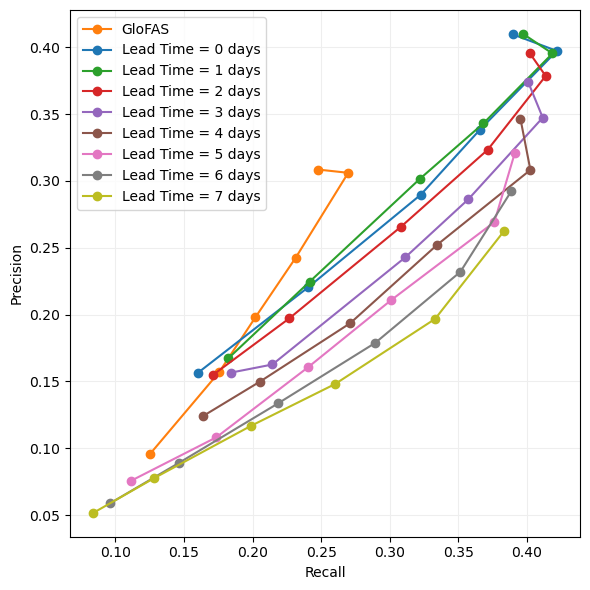

In [9]:
google_dataset = 'google_2014'
google_experiment = 'kfold_splits'
glofas_dataset = 'glofas_1980'
glofas_experiment = 'glofas_reanalysis'

fig = plt.figure(figsize=(6, 6))

lead_time = 0
d1 = {
    'recall': recalls_by_lead_time[google_dataset][google_experiment][lead_time],
    'precision': precisions_by_lead_time[google_dataset][google_experiment][lead_time],
}
d2 = {
    'recall': recalls_by_lead_time[glofas_dataset][glofas_experiment][lead_time],
    'precision': precisions_by_lead_time[glofas_dataset][glofas_experiment][lead_time]
}
df1 = pd.concat(d1, axis=1, keys=d1.keys())
df2 = pd.concat(d2, axis=1, keys=d2.keys())
df = pd.concat({google_experiment: df1, glofas_experiment: df2}, axis=1, keys=[google_experiment, glofas_experiment])

idx = pd.IndexSlice
plt.plot(
    df[idx[glofas_experiment, 'recall']].mean(),
    df[idx[glofas_experiment, 'precision']].mean(),
    'o-',
    c=evaluation_utils.EXPERIMENT_COLORS[glofas_experiment],
    label='GloFAS'
)

plt.plot(
    df[idx[google_experiment, 'recall']].mean(),
    df[idx[google_experiment, 'precision']].mean(),
    'o-',
    c=evaluation_utils.EXPERIMENT_COLORS[google_experiment],
    label=f'Lead Time = {lead_time} days'
)

for lead_time in data_paths.LEAD_TIMES[1:]:

    d1 = {
        'recall': recalls_by_lead_time[google_dataset][google_experiment][lead_time],
        'precision': precisions_by_lead_time[google_dataset][google_experiment][lead_time],
    }
    df = pd.concat(d1, axis=1, keys=d1.keys())

    color_idx = lead_time
    if lead_time > 0:
        color_idx = lead_time + 1

    plt.plot(
        df[idx['recall']].mean(),
        df[idx['precision']].mean(),
        'o-',
        c=evaluation_utils.COLORS[color_idx],
        label=f'Lead Time = {lead_time} days'
      )

plt.grid(c='#EEE')
plt.legend()
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.tight_layout()
plt.show()